<h1>Ising Model in Arbitrary Dimensions: Monte Carlo Simulations</h1>
<h4>William Pugsley </h4>

In [16]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from math import sqrt, cosh, sinh, log, exp, tanh

#this module contains the statistical functions used throughout the simulation
from my_math import *

#Thermodynamic constants
k_B = 1.380649e-23 #Units: J/K

<h2>Algorithm</h2>

The Monte Carlo algorithm we will use (Holmes-Cerfon 6-9) consists of creating a grid of positive and negative spins, this will be realized as a d-dimensional numpy array of +1 and -1 randomly. This algorithm will apply to any dimension d. We will randomly select a spin and calculate the energy change, $\Delta E$ associated with flipping the spin. The new state will be accepted with probability $Prob=W(\sigma',\sigma)$, where $W(\sigma',\sigma)$ satisfies the detailed balance equation (Grant 41); for our purposes this will be either the Glauber rule or the Metropolis rule. 

$W_{Metropolis}(\sigma',\sigma)=1 \; \Delta E \leq 0, \: e^{\frac{-\Delta E}{k_BT}} \; \Delta E \gt 0$

$W_{Glauber}(\sigma',\sigma)=\frac{1}{2}(1-tanh(\frac{\Delta E}{2k_BT}))$

We will do this N times for N total spins, this is one Monte Carlo cycle. Completing N cycles for our N spins will consist of one Monte Carlo simulation (Grant 45). At the end of a simulation we can calculate the total magnetization and the magnetization per spin; with these quantities we can verify our theoretical expectation of $<m>$. Repeating for diferent temperatures should yield the temperature dependence of $<m>$.

<h2>Ising Model in 4D+</h2>

The two-dimensional Ising model consists of an NxM rectangular lattice of spin sites, $S_i$, pointing in either the positive or negative direction.

$E_{state} = -J\Sigma_{<i,j>}S_iS_j-H\Sigma S_i$

Where <i,j> denotes nearest neighbor interactions with no double counting.

We will take this time to define the critical exponents of the Ising model:

* $\alpha \: : \: C_v \sim |T-T_C|^{-\alpha}, \: H=0$
* $\beta \: : \: m \sim (T_C-T)^{\beta}, \: H=0$
* $\gamma \: : \: \chi \sim |T-T_C|^{-\gamma}, \: H=0$
* $\delta \: : \: H \sim m^{\delta}, \: H\neq0$
* $\eta \: : \: <m(0)m(r)> \sim r^{(-d+2-\eta)}, \: H=0$
* $\nu \: : \: \xi \sim |T-T_C|^{-\nu}, \: H=0$

<h4>Setup</h4>

In [17]:
def init_grid(d, N):
    """ (int, int) -> (list)
    Creates an d-dimensional list with N rows, N columns, N pages, etc.
    """
    if d == 1:
        return [random.randrange(-1, 2, 2) for j in range(N)]
    else:
        return [init_grid(d-1,N) for i in range(N)]


def total_mag(grid):
    """ (np.array) -> (int)
    Returns the total magnetization of a numpy array (grid) of +1/-1.
    """
    return grid.sum()


def mag_per_spin(grid):
    """ (np.array) -> (float)
    Returns the magnetization per spin of a numpy array (grid).
    """
    return total_mag(grid)/grid.size


def energy(grid, H=0):
    """ (np.array, num) -> (num)
    """
    N = len(grid) #size
    d = len(grid.shape) #dimension

    E = 0

    for index, spin in np.ndenumerate(grid):
        for i in range(d): #row, col, page, ... neighbors
            new_idx = list(index)
            new_idx[i] = (new_idx[i]+1)%N #right neighbors
            E += spin*grid[tuple(new_idx)]

            new_idx[i] = (new_idx[i]-2)%N#left neighbors (two spots over)
            E += spin*grid[tuple(new_idx)]

    return -E/2 - H*total_mag(grid)

In [18]:
def energy_change(grid, index, H=0):
    """ (np.array, tuple, num) -> (num)
    Finds the change in energy associated with flipping the spin at the
    index positon in grid.
    """
    N = len(grid) #size
    d = len(grid.shape) #dimension

    if len(index) != d:
        raise ValueError("Index must have the same length as the dimension of grid.")
        
    E = 0
    for i in range(d):
        new_idx = list(index)
        new_idx[i] = (new_idx[i]+1)%N #right neighbors
        E += 2*grid[index]*grid[tuple(new_idx)]

        new_idx[i] = (new_idx[i]-2)%N#left neighbors (two spots over)
        E += 2*grid[index]*grid[tuple(new_idx)]

    return E + H*grid[index]


def glauber(grid, index, temp, H=0):
    """ (np.array, tuple, float, float) -> (float)
    Calculates the probability that a change of state occurs at the index location in grid.
    """
    E = energy_change(grid, index, H)
    return 0.5*(1 - tanh(0.5*E/temp))


def metropolis(grid, index, temp, H=0):
    """ (np.array, tuple, float, float) -> (float)
    Calculates the probability that a change of state occurs at the index location in grid.
    """
    E = energy_change(grid, index, H)
    if E <= 0:
        return 1
    return exp(-E/temp)


def flip(grid, index, temp, H=0, rule="metropolis"):
    """ (np.array, tuple, float, float, string) -> ()
    Flips the spin in grid at the index site with a probability given by the Metropolis or Glauber rule at temperature temp.
    """
    if rule == "glauber":
        prob = glauber(grid, index, temp, H)
    elif rule == "metropolis":
        prob = metropolis(grid, index, temp, H)
    else:
        raise ValueError("The rule argument take \"glauber\" or \"metropolis\" as input.")

    choice = random.uniform(0, 1)
    if choice <= prob: #will flip
        grid[index] *= -1
    #otherwise will not flip and nothing happens


def cycle(grid, temp, H=0, rule='metropolis'):
    """ (np.array, float, float, str) -> ()
    Will conduct one Monte Carlo cycle over grid at temperature temp. 
    """
    d = len(grid.shape) #dimension
    N = len(grid) #size

    for i in range(N**d):
        index = tuple([random.randint(0, N-1) for j in range(d)])
        flip(grid, index, temp, H, rule)


def simulation(grid, temp, H=0, rule='metropolis'):
    """ (np.array, float, float, str) -> ()
    Will conduct one Monte Carlo simulation over grid at temperature temp. 
    """
    d = len(grid.shape) #dimension
    N = len(grid) #size

    for i in range(N**d):
        cycle(grid, temp, H, rule)

<h4>Simulation</h4>

We will create a d-dimensional numpy array of NxNx...xN sites and run a total of num_sim Monte Carlo simulations before recording the magnetization per spin. We will do this num_points times, to get that many data points, at each temperature T in temperatues. Increasing num_points will get us a more precise measurement of the magnetization per spin at different temperatures. Increasing num_sim will let our experimental results approach the long-time thermodynamic limit. 

In [19]:
def full_sim_2d(d, N, num_points, num_sim, temperatures, H=0, output="mag", rule='metropolis'):
    """ (int, int, int, int, np.array, float, rule) -> (list, list) or (list, list, list, list)
    d: dimension of grid
    N: N**d is the total size of the grid
    num_points: number of data points at each temperature
    num_sim: total numer of simulations conducted on a strip
    temperatures: range of temperatues at which we will simulate
    H: the strength of the external field
    output: controls the value we are simulating for ("mag", "energy", or "both")
    """

    #the mean and standard_error functions come from my_math.py

    if output == "mag":
        magnetizations = [] #<m> of our simulations at various temperatues
        magnetizations_unc = [] #uncertainties in <m>

        for T in temperatures:
            m_at_t = []
            grid = np.array(init_grid(d, N))
            for i in range(num_sim): 
                cycle(grid, T, H, rule)
            for j in range(num_points):
                cycle(grid, T, H, rule)
                m_at_t.append(mag_per_spin(grid))
            magnetizations.append(abs(mean(m_at_t)))
            magnetizations_unc.append(standard_error(m_at_t))
        return magnetizations, magnetizations_unc
    elif output == "energy":
        energies = [] #<m> of our simulations at various temperatues
        energies_unc = [] #uncertainties in <m>
        size = N**d

        for T in temperatures:
            e_at_t = []
            grid = np.array(init_grid(d, N))
            for i in range(num_sim): 
                cycle(grid, T, H, rule)
            for j in range(num_points): 
                cycle(grid, T, H, rule)
                e_at_t.append(energy(grid)/size)
            energies.append(mean(e_at_t))
            energies_unc.append(standard_error(e_at_t))
        return energies, energies_unc
    elif output == "both":
        energies = [] #<m> of our simulations at various temperatues
        energies_unc = [] #uncertainties in <m>
        magnetizations = [] #<m> of our simulations at various temperatues
        magnetizations_unc = [] #uncertainties in <m>
        size = N**d
        
        for T in temperatures:
            e_at_t = []
            m_at_t = []
            grid = np.array(init_grid(d, N))
            for i in range(num_sim): 
                cycle(grid, T, H, rule)
            for j in range(num_points): 
                cycle(grid, T, H, rule)
                e_at_t.append(energy(grid)/size)
                m_at_t.append(mag_per_spin(grid))
            energies.append(mean(e_at_t))
            energies_unc.append(standard_error(e_at_t))
            magnetizations.append(abs(mean(m_at_t)))
            magnetizations_unc.append(standard_error(m_at_t))
        return energies, energies_unc, magnetizations, magnetizations_unc
    else:
        raise ValueError("The output parameter must be \"mag\", \"energy\", or \"both\".")

<h4>H=0</h4>

The mean field results, or the results we expect from the Monte Carlo method of simulation are (Grant 149):
* $\alpha=0$
* $\beta=1/2$
* $\gamma=1$
* $\delta=3$
* $\eta=0$
* $\nu=1/2$


In [20]:
#these values will be stored in separate variables so that we may easily change them
d= 4
N = 5
num_points = 50
num_sim = 3
temperatures_h_0 = np.linspace(0.1, 4, 50) #the range of temperatures over which we will run our simulation

energies, energies_unc, magnetizations, magnetizations_unc = full_sim_2d(d, N, num_points, num_sim, temperatures_h_0, 0, "both") #run the simulation

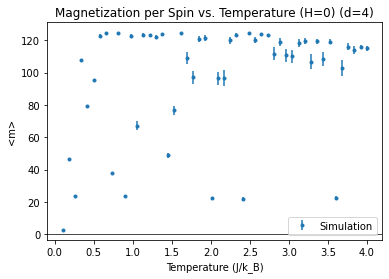

'\nplt.figure()\n\nres = [magnetizations[i]-exp_m_h0[i] for i in range(len(magnetizations))]\n\nplt.errorbar(x=temperatures_h_0, y=res, yerr=magnetizations_unc, ls=\'\', marker=\'.\')\n\nplt.title("Residuals of Magnetization per Spin vs. Temperature (H=0)")\nplt.xlabel("Temperature (J/k_B)")\nplt.ylabel("<m>")\nplt.axhline(color=\'k\', lw=0.7)\nplt.show()\n'

In [25]:
plt.figure()

plt.errorbar(x=temperatures_h_0, y=magnetizations, yerr=magnetizations_unc, marker='.', ls='', label='Simulation')

plt.title("Magnetization per Spin vs. Temperature (H=0) (d=" + str(d) +')')
plt.xlabel("Temperature (J/k_B)")
plt.ylabel("<m>")
plt.axhline(color='k', lw=0.7)
plt.legend()
plt.show()

#plotting residuals
"""
plt.figure()

res = [magnetizations[i]-exp_m_h0[i] for i in range(len(magnetizations))]

plt.errorbar(x=temperatures_h_0, y=res, yerr=magnetizations_unc, ls='', marker='.')

plt.title("Residuals of Magnetization per Spin vs. Temperature (H=0)")
plt.xlabel("Temperature (J/k_B)")
plt.ylabel("<m>")
plt.axhline(color='k', lw=0.7)
plt.show()
"""

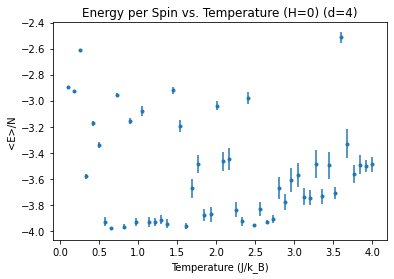

In [28]:
plt.figure()

plt.errorbar(x=temperatures_h_0, y=energies, yerr=energies_unc, marker='.', ls='', label='Simulation')

plt.title("Energy per Spin vs. Temperature (H=0) (d=" + str(d) +')')
plt.xlabel("Temperature (J/k_B)")
plt.ylabel("<E>/N")
plt.show()

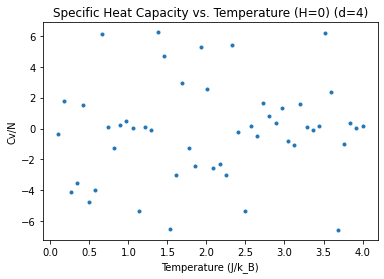

In [29]:
c_v_h_0 = list_derivative(temperatures_h_0, energies)

plt.figure()

plt.plot(temperatures_h_0, c_v_h_0, marker='.', ls='', label='Simulation')

plt.title("Specific Heat Capacity vs. Temperature (H=0) (d=" + str(d) +')')
plt.xlabel("Temperature (J/k_B)")
plt.ylabel("Cv/N")
plt.show()

<h4>H&#8800;0</h4>

<h2>Sources</h2>

* Grant, Martin. <em>Dirty tricks for statistical mechanics</em>. 2004.
    * Available here: <http://www.physics.mcgill.ca/~grant/559/notes0.91.pdf>
* Holmes-Cerfon, Miranda. <em>Lecture 3: Markov Chains (II): Detailed Balance, and Markov Chain Monte Carlo (MCMC)</em>. 2019.
    * Available here: <https://cims.nyu.edu/~holmes/teaching/asa19/handout_Lecture3_2019.pdf>
* Pathria, R. K., and Paul D. Beale. <em>Statistical Mechanics</em>. Elsevier, 2011. 
* Salinas S.R.A. <em>Introduction to Statistical Physics</em>. 2001. Graduate Texts in Contemporary Physics. Springer, New York, NY. <https://doi.org/10.1007/978-1-4757-3508-6_13>
    * Relevant chapter available here: <http://www.lps.ens.fr/~krzakala/ISINGMODEL.pdf>


In [33]:
test = np.array(init_grid(4,5))

In [36]:
test.size

625